#  Flow Over Cylinder

I am not able to produce correct results beacause of some bug in the code which i am unable to find. 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt 
import numba


In [2]:
@numba.njit
def cylinder_panels(panels, R):
    theta = np.linspace(0,2*math.pi,panels+1)
    start_points = np.zeros(panels, dtype=np.cfloat)
    end_points = np.zeros(panels, dtype=np.cfloat)
    
    start_points = np.cos(theta[:-1]) + 1j*np.sin(theta[:-1])
    end_points = np.cos(theta[1:]) + 1j*np.sin(theta[1:])
    return start_points, end_points


#def panels

In [3]:
@numba.njit
def velocity_dueto_vortices(control_point, gammas, positions):              #velocity due to vortices present in flow
    velocity_due_vortices = (0+1j*0)
    for i in range(len(gammas)):
        z_relative = control_point - positions[i]
        v_conjugate = complex(0,-1)*(gammas[i])/(2*(np.pi)*(z_relative))
        velocity  = v_conjugate.conjugate()
        velocity_due_vortices += velocity
        return velocity_due_vortices
        
        

In [4]:
@numba.njit
def chorin_velocity(circulation, self_position, other_position, delta):
    z_relative = self_position - other_position
    zc = z_relative.conjugate()
    modulus = abs(z_relative)
    x=z_relative.real
    y=z_relative.imag
    if modulus <= delta and modulus !=0:
        velocity_conj = complex(0,-1)*circulation/(2*np.pi*zc*(1/abs(modulus*delta)))
        velocity = velocity_conj.conjugate()
    elif modulus == 0:
        velocity = complex(0,0)
    else:
        v_conjugate = complex(0,-1)*(circulation)/(2*(np.pi)*(z_relative))
        velocity  = v_conjugate.conjugate()
    return velocity

In [5]:
@numba.njit
def velocity_dueto_blobs(control_point, gammas_blobs, positions_blobs, delta):
    velocity_due_blobs = (0+1j*0)
    for i in range(len(gammas_blobs)):
        velocity_due_blobs += chorin_velocity(control_point, gammas_blobs[i], positions_blobs[i], delta)
        
    return velocity_due_blobs
        

In [6]:
@numba.njit
def gamma_panels_calculation(circulations_linear, start_points, end_points):
    n=len(circulations_linear)
    gamma_panels = np.zeros(n)
    lamda = abs(start_points[0]-end_points[0])
    for i in range(n):
        if i != (n-1):
            gamma_panels[i] = (circulations_linear[i]+circulations_linear[i+1])/2
        elif i == (n-1):
            gamma_panels[i] = (circulations_linear[i]+circulations_linear[0])/2
    return gamma_panels       



In [7]:
def gamma_position_blob(circulations_linear, start_points, end_points, gamma_max):
    lamda = abs(start_points[0]-end_points[0])
    delta = abs(start_points[0]-end_points[0])/np.pi
    all_blobs_pos = np.array([])
    all_blobs_gamma = np.array([])
    gamma_panels = gamma_panels_calculation(circulations_linear, start_points, end_points)
    delta = abs(start_points[0]-end_points[0])/np.pi
    for i in range(len(circulations_linear)):
        control_point  = (end_points[i]+start_points[i])/2
        gamma1, pos1 = blob_split(control_point, circulations_linear[i], gamma_max, delta,lamda)
        all_blobs_pos = np.concatenate((all_blobs_pos, pos1), axis=0) 
        all_blobs_gamma = np.concatenate((all_blobs_gamma, gamma1), axis=0)
    return all_blobs_gamma, all_blobs_pos
        
        

In [8]:
@numba.njit
def blob_split(control_point, gamma_panel, gamma_max, delta, lamda):
    
    r = abs(control_point)
    theta = control_point/r
    g = abs(gamma_panel)
    if (g%gamma_max) !=0 :
        num_of_blobs = int(g//gamma_max+1)
        gamma_blob = gamma_max*lamda
        gamma_blob_rem = (g%gamma_max)*lamda
        gammas_blobs = np.zeros(num_of_blobs)
        gammas_blobs[:-1] = gamma_blob*(gamma_panel/abs(gamma_panel))
        gammas_blobs[-1] = gamma_blob_rem*(gamma_panel/abs(gamma_panel))
        positions_blobs = np.zeros(num_of_blobs, dtype=np.cfloat)
        positions_blobs[:] = (r+delta)*theta
    elif (g%gamma_max) ==0 :
        num_of_blobs = int(g/gamma_max)
        gamma_blob = (gamma_max)*lamda
        gammas_blobs = np.zeros(num_of_blobs)
        gammas_blobs[:] = gamma_blob*(gamma_panel/abs(gamma_panel))
        positions_blobs = np.zeros(num_of_blobs, dtype=np.cfloat)
        positions_blobs[:] = (r+delta)*theta

    return gammas_blobs, positions_blobs
            
        
        

In [9]:
start_points,  end_points = cylinder_panels(70,1)

In [10]:
@numba.njit
def dot(a,b):
    return a.real*b.real + a.imag*b.imag

In [11]:
def matrix_A_linear(start_points, end_points):
    n = len(start_points)
    noraml = 1j*(start_points-end_points)/abs(start_points-end_points)
    A = np.zeros((n+1, n))
    for i in range(n):
        control_point = (end_points[i]+start_points[i])/2
        for j in range(n):
            panel_vector = end_points[j]-start_points[j]
            l = abs(panel_vector)
            relative_vector = control_point - start_points[j]
            angle_panel = panel_vector/l
            conjugate_panel = angle_panel.conjugate()
            rva = relative_vector*conjugate_panel
            vel1 = -1j*(((rva/l)-1)*(np.log(1-(l/rva)))+1)
            vel2 = 1j*((rva/l)*(np.log(1-(l/rva)))+1)
            v1 = (vel1.conjugate())*angle_panel
            v2 = (vel2.conjugate())*angle_panel
            if j!= n-1:
                A[i][j]+=dot(v1,noraml[i])
                A[i][j+1]+=dot(v2,noraml[i])
            elif j == n-1:
                A[i][j]+=dot(v1,noraml[i])
                A[i][0]+=dot(v2,noraml[i])
    A[n]= 1
    return A
                
#matrix A (cofficients of gammas of panels) using standerd formulae

In [12]:
def matrix_b(start_points, end_points,velocity_body=0+1j*0, gammas=np.array([]), positions=0,gammas_blobs=np.array([]), positions_blobs=0, v_inf=1):
    delta = abs(start_points[0]-end_points[0])/np.pi
    n = len(start_points)
    v=np.zeros(n, dtype=np.cfloat)
    normal=np.zeros(n, dtype=np.cfloat)
    normal = 1j*(start_points-end_points)/abs(start_points-end_points)
    for i in range(n):
        control_point = (start_points[i]+end_points[i])/2
        if len(gammas) !=0:
            velocity_due_vortices = velocity_dueto_vortices(control_point,gammas,positions)
        else:
            velocity_due_vortices = 0
        if len(gammas_blobs) != 0:
            velocity_due_blobs = velocity_dueto_blobs(control_point, gammas_blobs, positions_blobs,delta)
        else:
            velocity_due_blobs = 0
        v[i] = velocity_body - (v_inf+1j*0) - velocity_due_vortices - velocity_due_blobs
        b = dot(v,normal)
    b= np.append(b,0)
    return b
        
#remain same as in prevoius

In [13]:
A_linear = matrix_A_linear(start_points, end_points)
b_linear = matrix_b(start_points, end_points, v_inf=1)

In [14]:
def solve(A,b):
        ans = np.linalg.lstsq(A, b, rcond=None)[0]
        return ans

In [15]:
circulations_linear = solve(A_linear,b_linear)

In [16]:
all_blobs_gamma, all_blobs_pos = gamma_position_blob(circulations_linear, start_points, end_points, 0.1)

In [17]:
@numba.njit
def blob_velocity_panel(blob_position, start_point, end_point, circulation):
    panel_vector = end_point-start_point
    l = abs(panel_vector)
    control_point = (start_point+end_point)/2
    relative_vector = blob_position - start_point
    angle_panel = panel_vector/l
    conjugate_panel = angle_panel.conjugate()
    rva = relative_vector*conjugate_panel
    vel1 = -1j*(circulation)*(((rva/l)-1)*(np.log(1-(l/rva)))+1)
    vel2 = 1j*(circulation)*((rva/l)*(np.log(1-(l/rva)))+1)
    v1 = (vel1.conjugate())*angle_panel
    v2 = (vel2.conjugate())*angle_panel
    velocity = v1 + v2
    return velocity

#velocity function of particle outside cylinder using linear intensity panel discretization

In [18]:
@numba.njit
def blob_velocity_due_blob(circulation, self_position, other_position, delta):
    z_relative = self_position - other_position
    zc = z_relative.conjugate()
    modulus = abs(z_relative)
    x=z_relative.real
    y=z_relative.imag
    if modulus <= delta and modulus !=0:
        velocity = complex(0,-1)*circulation/(2*np.pi*zc*(1/abs(modulus*delta)))
        velocity = velocity.conjugate()
    elif modulus == 0:
        velocity = complex(0,0)
    else:
        v_conjugate = -1j*(circulation)/(2*(np.pi)*(z_relative))
        velocity  = v_conjugate.conjugate()
    return velocity

In [19]:
@numba.njit
def total_velocity_blobs(all_blobs_positions, all_blobs_gammas, start_points, end_points, circulations_linear,v,v_inf=1):
    delta = abs(start_points[0]-end_points[0])/np.pi
    for i in range(len(all_blobs_positions)):
        for j in range(len(start_points)):
            v[i] += blob_velocity_panel(all_blobs_positions[i],start_points[j], end_points[j], circulations_linear[j])
        for k in range(len(all_blobs_positions)):
            if i != k:
                v[i]+= blob_velocity_due_blob(all_blobs_gammas[k], all_blobs_positions[i], all_blobs_positions[k], delta)
        v[i]+= (v_inf + 1j*0)
    return v
            
#velocity of all particles due to all panels, free stream

In [20]:
@numba.njit
def diffusion(positions, nu, dt):
    sigma = np.sqrt(2*nu*dt)
    positions_copy = positions.copy()
    x = positions_copy.real
    y = positions_copy.imag
    xn = x + np.random.normal(0,nu)
    yn = y + np.random.normal(0,nu)
    z = xn + 1j*yn
    return z

In [21]:
#posss2_adv = RK2(posss2, all_blobs_gamma, start_points, end_points, circulations_linear, 0.1

In [22]:
@numba.njit
def reflect(positions, origin, r):
    for i in range(len(positions)):
        vec = positions[i] - origin
        if abs(vec) <= r and abs(vec) != 0:
            positions[i] = origin + (2*r - abs(vec))*(vec/abs(vec))
    return positions


In [23]:
@numba.njit
def euler(all_blobs_positions, all_blobs_gammas, start_points, end_points, circulations_linear, dt, v_inf=1):
    new_positions = np.zeros(shape=(len(all_blobs_positions)),dtype=np.cfloat)
    v=np.zeros(len(all_blobs_positions),dtype=np.cfloat)
    velocity = total_velocity_blobs(all_blobs_positions, all_blobs_gammas, start_points, end_points, circulations_linear,v, v_inf=1 )
    for i in range(len(all_blobs_positions)):
        new_positions[i] = all_blobs_positions[i] + velocity[i]*dt
    return new_positions

@numba.njit
def RK2(all_blobs_positions, all_blobs_gammas, start_points, end_points, circulations_linear, dt, v_inf=1):
    new_positions = np.zeros(shape=(len(all_blobs_positions)),dtype=np.cfloat)
    v=np.zeros(len(all_blobs_positions),dtype=np.cfloat)
    vi = total_velocity_blobs(all_blobs_positions, all_blobs_gammas, start_points, end_points,circulations_linear, v, v_inf=1)
    temp_positions = euler(all_blobs_positions, all_blobs_gammas, start_points, end_points, circulations_linear, dt, v_inf=1)
    vi1 = total_velocity_blobs(temp_positions, all_blobs_gammas, start_points, end_points, circulations_linear,v, v_inf=1)
    for i in range(len(all_blobs_positions)):
        new_positions[i] = all_blobs_positions[i] + (vi[i]+vi1[i])*dt/2
    return new_positions, vi, vi1

In [24]:
def integrate(number_panels, R, gamma_max, Re, dt, timesteps, v_inf=1):
    v1 = []
    v2 = []
    data = []
    gamma_blob = []
    nu = (v_inf*2*R)/Re
    start_points, end_points = cylinder_panels(number_panels, R)
    A_linear = matrix_A_linear(start_points, end_points)
    b_linear = matrix_b(start_points, end_points, v_inf=1)
    circulations_linear = solve(A_linear,b_linear)
    all_blobs_gamma, all_blobs_pos = gamma_position_blob(circulations_linear, start_points, end_points, 0.1)
    blobs_before_diff = np.copy(all_blobs_pos)
    pos1 = diffusion(all_blobs_pos, nu, dt)
    pos2 = reflect(pos1, complex(0,0), 1)
    data.append(pos2.copy())
    gamma_blob.append(all_blobs_gamma.copy())
    for i in range(1,timesteps,1):
        b_linear = matrix_b(start_points, end_points, gammas_blobs=all_blobs_gamma, positions_blobs= pos2, v_inf=1)
        circulations_linear = solve(A_linear, b_linear)
        new_blob_gamma, new_blob_pos = gamma_position_blob(circulations_linear, start_points, end_points, 0.1)
        print(sum(new_blob_gamma))
        blobs_advection, vi, vi1 = RK2(pos2, all_blobs_gamma, start_points, end_points,circulations_linear, dt, v_inf=1)
        v1.append(vi)
        v2.append(vi1)
        blobs_advection = reflect(blobs_advection, complex(0,0), 1)
        #data.append(blobs_advection.copy())
        #gamma_blob.append(all_blobs_gamma.copy())
        blobs_before_diff = np.concatenate((blobs_advection, new_blob_pos), axis=0)
        pos1 = diffusion(blobs_before_diff, nu, dt)
        pos2 = reflect(pos1, complex(0,0),1)
        data.append(pos2)
        all_blobs_gamma = np.concatenate((all_blobs_gamma, new_blob_gamma), axis=0)
        print(np.shape(all_blobs_gamma))
        gamma_blob.append(all_blobs_gamma)
        print(i)
    return data, gamma_blob, v1, v2
        
        
        
    

In [25]:
data1, gamma_blob1, v1 ,v2 = integrate(70, 1, 0.1, 1000, 0.1, 12)

4.215378046623641e-16
(362,)
1
2.8857125022874186e-15
(1353,)
2
1.850949948867253e-15
(3035,)
3
1.9719469113166355e-15
(4796,)
4
9.99634403031635e-16
(6969,)
5
-1.6219664500383146e-15
(9405,)
6
5.257513174816708e-15
(22935,)
7
-2.742597815519332e-15
(27771,)
8
3.0075768264747893e-15
(31782,)
9
1.7156415177410622e-15
(37219,)
10
2.3955663841501718e-14
(45389,)
11


In [26]:
def color(circulations):
    c=[]
    for i in range(len(circulations)):
        if circulations[i] > 0:
            c.append("b")
        else:
            c.append("r")
    return c

In [27]:
a= color(gamma_blob1[-1])

In [28]:
#data, gamma_blob = integrate(70, 1, 0.1, 1000, 0.1, 0)

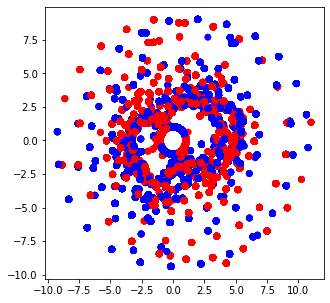

In [29]:
plt.figure(figsize=(5,5))
plt.scatter(data1[-1].real, data1[-1].imag, c=a)

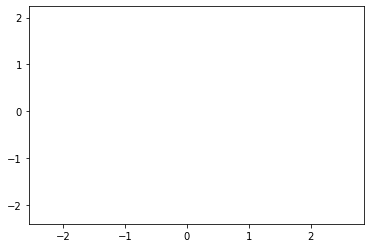

In [30]:
import matplotlib
from matplotlib import pyplot as plt
from celluloid import Camera

fig = plt.figure()
camera = Camera(fig)
for i in range(5):
    plt.scatter(data1[i].real,data1[i].imag,c=color(gamma_blob1[i]))
    #plt.plot(data_trial[i][n:2*n].real,data_trial[i][n:2*n].imag, 'r.')
    camera.snap()
animation = camera.animate()
animation.save('flow_over_cylinder.mp4')                                    #for animation

functions for velocity of tracer points outside the cylinder

In [31]:
def velocity_tracer_linear(tracer_position, start_point, end_point, circulation):
    panel_vector = end_point-start_point
    l = abs(panel_vector)
    control_point = (start_point+end_point)/2
    relative_vector = tracer_position - start_point
    angle_panel = panel_vector/l
    conjugate_panel = angle_panel.conjugate()
    rva = relative_vector*conjugate_panel
    vel1 = -1j*(circulation)*(((rva/l)-1)*(np.log(1-(l/rva)))+1)
    vel2 = 1j*(circulation)*((rva/l)*(np.log(1-(l/rva)))+1)
    v1 = (vel1.conjugate())*angle_panel
    v2 = (vel2.conjugate())*angle_panel
    velocity = v1 + v2
    return velocity

#velocity function of particle outside cylinder using linear intensity panel discretization

In [32]:
def total_velocity_tracer_linear(tracer_positions, start_points, end_points, circulations_linear,v,v_inf=0):
    for i in range(len(tracer_positions)):
        for j in range(len(start_points)):
            v[i] += velocity_tracer_linear(tracer_positions[i],start_points[j], end_points[j], circulations_linear[j])
        v[i]+= (v_inf + 1j*0)
    return v
            
#velocity of all particles due to all panels, free stream

In [33]:
def problem_cylinder(number,R):
    theta = np.linspace(0,2*np.pi,number)
    tracer_positions = np.zeros(number, dtype=np.cfloat)
    for i in range(number):
        tracer_positions[i] = complex(R*np.cos(theta[i]),R*np.sin(theta[i]))
    return tracer_positions
    
#def points outside the cylinder

In [34]:
tracer_positions = problem_cylinder(200,2)


In [35]:
v=np.zeros(len(tracer_positions),dtype=np.cfloat)
exp_velocity = total_velocity_tracer_linear(tracer_positions, start_points, end_points, circulations_linear,v, v_inf=1)